In [19]:
import numpy as np
from control import matlab
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# 9.5 数値シミュレーション
- control.matlab.lqrに最適レギュレータが実装されている
    - 関数から帰ってくるF,X,Eは
        - F:フィードバックゲイン
        - X:リカッチ方程式の解
        - E:閉ループ系の極

In [36]:
output_names = ["発電機端子電圧", "発電機内部相差角"]
input_names = ["励磁機制御系の設定電圧", "タービンへの蒸気流量"]
A = np.array(pd.read_csv("./data/sim1/sys_A.csv", header=None))
B = np.array(pd.read_csv("./data/sim1/sys_b.csv", header=None))
C = np.array(pd.read_csv("./data/sim1/sys_c.csv", header=None))

Pss = matlab.ss(A, B, C, 0)

In [3]:
Q = np.diag([10]*9)
R = np.diag([10]*2)

In [4]:
F, X, E = matlab.lqr(Pss.A, Pss.B, Q, R)

In [5]:
display(np.linalg.eigvals(A))
# display(np.linalg.eigvals(A-np.dot(B,F)))
display(E)

array([-1.06803978e+02+15.80269197j, -1.06803978e+02-15.80269197j,
       -6.22446902e-02+10.4594185j , -6.22446902e-02-10.4594185j ,
       -1.29873340e+01 +0.j        , -3.40349396e+01 +9.95086901j,
       -3.40349396e+01 -9.95086901j, -2.96303407e+01 +0.j        ,
       -5.00000000e+00 +0.j        ])

array([-107.930374 +15.291009j, -107.930374 -15.291009j,
        -34.78741   +9.299614j,  -34.78741   -9.299614j,
        -29.380627  +0.j      ,   -9.922343 +13.230641j,
         -9.922343 -13.230641j,  -11.765754  +0.j      ,
         -3.1871777 +0.j      ], dtype=complex64)

In [26]:
Td = np.arange(0, 5, 0.01) #シミュレーション時間0~1s,0.01s刻み
Ud = 0*(Td>0) #入力信号（ステップ入力）

X0 = [1]*9 # 初期状態量
sys = matlab.ss(Pss.A-np.dot(Pss.B,F), Pss.B, C, 0)
y, tt, x = matlab.lsim(sys, np.vstack((Ud,Ud)).T, Td, X0) #線形システムシミュレータ

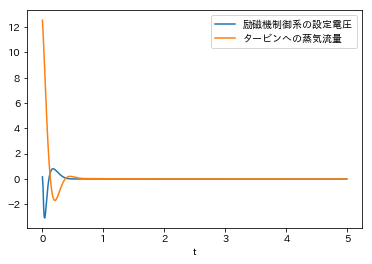

In [38]:
df = pd.concat((pd.DataFrame(tt),pd.DataFrame(np.dot(x, -F.T))), axis = 1)
df.columns = ["t", input_names[0], input_names[1]]
df.plot(x = "t")

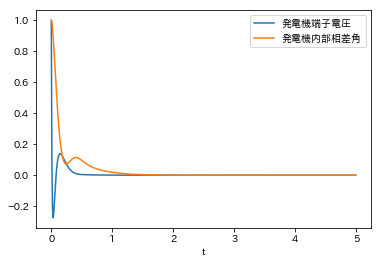

In [22]:
df = pd.concat((pd.DataFrame(tt), pd.DataFrame(y)), axis = 1)
df.columns = ["t", output_names[0], output_names[1]]
df.plot(x = "t")

In [23]:
y, tt = matlab.initial(sys, Td, X0)

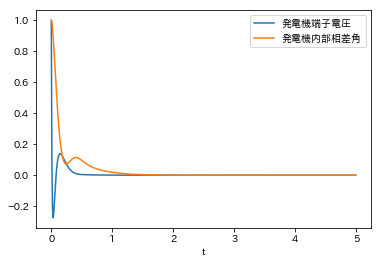

In [24]:
df = pd.concat((pd.DataFrame(tt), pd.DataFrame(y)), axis = 1)
df.columns = ["t", output_names[0], output_names[1]]
df.plot(x = "t")

# ハマりメモ1
- slycotモジュールが入ってなくて最初エラーでた
    - `pip install slycot` だけでは入らなかった
        - `sudo apt-get install gfortran`と
        - `sudo apt-get install libblas-dev liblapack-dev`した後もう一度`pip install slycot`したらslycotが入ってlqrもちゃんと走るようになった

# ハマりメモ２
- なぜか`matlab.lsim`実行時にカーネルリスタートする現象が起きた
- 何が効いたのかわからないが以下のようにすると動くようになった
    - slycotのバージョンを0.4.0->0.3.5に落とした
    - その後、numpyのバージョンを上げた
    - jupyter-labじゃなくてjupyter 